In [35]:
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns

## Helper Methods

In [36]:
colormap = plt.cm.RdBu_r

def has_index(info_list, index):
    try:
        item = info_list[index]
        return item
    except IndexError:
        return False

def get_date(value):
    date_data = str(value)[-6:]
    base_year = date_data[:2]
    prefix = '20' if int(base_year) < 18 else '19'
    year = prefix + base_year
    return year + '-' + date_data[2:4] + '-' + date_data[4:6]

def get_time(value):
    value = str(value)
    return (value[:-2] if value[:-2] != "" else "00") + ":" + value[-2:]

def get_macintosh_class(value):
    value_list = str(value).split(' ')
    if has_index(value_list, 1) is not False:
        expected_mcintosh_class = str(value_list[1])
        if re.match(r"^[A-Z]{2,3}$", expected_mcintosh_class):
            return expected_mcintosh_class
        return float('nan')
    return float('nan')

def get_spot_noaa(value):
    value_list = str(value).split(' ')
    if has_index(value_list, 1) is not False:
        return value_list[0]
    return float('nan')

def metrics_box_plot(model_name, accuracy_s, precision_s, recall_s, f1_s):
    print(model_name + "Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))
    print(model_name + 'Average Accuracy Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(accuracy_scores.mean(),accuracy_scores.quantile(.05),accuracy_scores.quantile(.95),))
    print(model_name + "Precision: %0.2f (+/- %0.2f)" % (precision_scores.mean(), precision_scores.std() * 2))
    print(model_name + 'Average Precision Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(precision_scores.mean(),precision_scores.quantile(.05),precision_scores.quantile(.95),))
    print(model_name + "Recall: %0.2f (+/- %0.2f)" % (recall_scores.mean(), recall_scores.std() * 2))
    print(model_name + 'Average Recall Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(recall_scores.mean(),recall_scores.quantile(.05),recall_scores.quantile(.95),))
    print(model_name + "F1: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))
    print(model_name + 'Average F1 Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(f1_scores.mean(),f1_scores.quantile(.05),f1_scores.quantile(.95),))
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    # Create a box plot for metrics a
    axs[0].boxplot(accuracy_s)
    axs[1].boxplot(precision_s)
    axs[2].boxplot(recall_s)
    axs[3].boxplot(f1_s)

    # Set the title and axis labels for each subplot
    axs[0].set_title('Distribution of classifier accuracy')
    axs[1].set_title('Distribution of classifier precision')
    axs[2].set_title('Distribution of classifier recall')
    axs[3].set_title('Distribution of classifier f1')
    axs[0].set_ylabel('Value')

    # Show the plot
    plt.show()

def plot_roc_curve(model_, x_scaled_, y_train_resampled_, x_test_, y_test_):
    # Calculate the false positive rate, true positive rate, and thresholds for the training data
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_resampled_, model_.predict_proba(x_scaled_)[:, 1])
    auc_train = roc_auc_score(y_train_resampled_, model.predict_proba(x_scaled_)[:, 1])

    # Calculate the false positive rate, true positive rate, and thresholds for the testing data
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test_, model.predict_proba(x_test_)[:, 1])
    auc_test = roc_auc_score(y_test_, model.predict_proba(x_test_)[:, 1])

    # Plot the ROC curve and AUC score for the training data
    plt.plot(fpr_train, tpr_train, label='Training ROC curve (AUC = %0.2f)' % auc_train)

    # Plot the ROC curve and AUC score for the testing data
    plt.plot(fpr_test, tpr_test, label='Testing ROC curve (AUC = %0.2f)' % auc_test)

    # Add labels and title to the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Dataset Preprocessing

### Reading Sunspots Dataset

In [37]:
spots = pd.read_fwf("datasets/spots1981-2017.txt", header=None)
spots.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,11811201,21,N13W46 BG,NaN,NaN,3478 EKI,32.0,12.0,600.0,811127.5,811127.5,938,4LEAR
1,11811201,115,N13W46,NaN,NaN,3478 EHI,16.0,11.0,530.0,811127.6,811127.5,205,2MANI
2,11811201,210,N12W47 BG,NaN,NaN,3478 EHO,22.0,14.0,710.0,811127.5,811127.5,626,2PALE
3,11811201,1355,N15W56 BG,NaN,NaN,3478 EHI,31.0,13.0,670.0,811127.3,811127.5,468,2RAMY
4,11811201,1535,N13W55 BG,NaN,NaN,3478 EHI,17.0,13.0,430.0,811127.5,811127.5,624,2HOLL


### Reading Solar Flares Dataset

In [38]:
flares = pd.read_fwf("datasets/flares1981-2017.txt", header=None)
flares.head()

,0,1,2,3,4,5,6,7,8,9
0,31777810102,441,446,0444,NaN,C,18.0,GOES,NaN,NaN
1,31777810102,955,1004,1000,NaN,C,18.0,GOES,NaN,NaN
2,31777810103,1025,1036,1030,NaN,C,51.0,GOES,NaN,NaN
3,31777810103,1549,1558,1553,NaN,C,22.0,GOES,2857.0,NaN
4,31777810103,1837,1845,1842,NaN,C,22.0,GOES,NaN,NaN


### Labeling flares & dropping unwanted features

In [39]:
flares.drop(axis=1, labels=[4,7,9], inplace=True)
flares.columns = ['Date', 'Start Time',  'End Time', 'Peak Time', 'X-ray Class', 'Flare Magnitude', 'NOAA']
flares.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71984 entries, 0 to 71983
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             71984 non-null  int64  
 1   Start Time       71984 non-null  int64  
 2   End Time         71984 non-null  int64  
 3   Peak Time        71916 non-null  object 
 4   X-ray Class      71957 non-null  object 
 5   Flare Magnitude  71954 non-null  float64
 6   NOAA             38704 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 3.8+ MB


### Labeling sun spots & dropping unwanted features

In [40]:
spots.drop(axis=1, labels=[2,3,4,7,8,9,10,11,12], inplace=True)
spots.columns = ['Date', 'Time', 'McIntosh & NOAA', 'Number of Spots']
flares.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71984 entries, 0 to 71983
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             71984 non-null  int64  
 1   Start Time       71984 non-null  int64  
 2   End Time         71984 non-null  int64  
 3   Peak Time        71916 non-null  object 
 4   X-ray Class      71957 non-null  object 
 5   Flare Magnitude  71954 non-null  float64
 6   NOAA             38704 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 3.8+ MB


### Remove record with bad time from solar flares

In [41]:
rows_with_bad_time = flares.loc[(flares['Start Time'] > 2359) | (flares['End Time'] > 2359)]
flares.drop(rows_with_bad_time.index, inplace=True)
flares.dropna(inplace=True)
flares.reset_index(inplace=True)
flares.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38313 entries, 0 to 38312
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            38313 non-null  int64  
 1   Date             38313 non-null  int64  
 2   Start Time       38313 non-null  int64  
 3   End Time         38313 non-null  int64  
 4   Peak Time        38313 non-null  object 
 5   X-ray Class      38313 non-null  object 
 6   Flare Magnitude  38313 non-null  float64
 7   NOAA             38313 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 2.3+ MB


### Reformat solar flares date and time

In [42]:
flares['Date'] = flares['Date'].apply(get_date)
flares['Start Time'] = flares['Start Time'].apply(get_time)
flares['End Time'] = flares['End Time'].apply(get_time)
flares['Peak Time'] = flares['Peak Time'].apply(get_time)
flares.drop(axis=1, labels=['index'], inplace=True)
flares.shape

(38313, 7)

### Inspect and remove bad time from solar flares

In [43]:
indexNames = flares.loc[flares['Peak Time'] == '//://'].index
flares.drop(indexNames , inplace=True)
indexNames = flares.loc[flares['Start Time'] == '//://'].index
flares.drop(indexNames , inplace=True)
indexNames = flares.loc[flares['End Time'] == '//://'].index
flares.drop(indexNames , inplace=True)
flares.shape

(38312, 7)

### Modifying solar flares features

In [44]:
flares['Start Time'] = flares['Date'].str.cat(flares['Start Time'], sep=' ')
flares['End Time'] = flares['Date'].str.cat(flares['End Time'], sep=' ')
flares['Peak Time'] = flares['Date'].str.cat(flares['Peak Time'], sep=' ')
flares['Start Time'] = pd.to_datetime(flares['Start Time'])
flares['End Time'] =  pd.to_datetime(flares['End Time'])
flares['Peak Time'] =  pd.to_datetime(flares['Peak Time'])
flares['Flare Duration'] = (flares['End Time'] - flares["Start Time"]).dt.total_seconds() / 60
flares['Date'] = pd.to_datetime(flares['Date'])
flares['Year'] = flares['Date'].dt.year
flares['NOAA'] = flares['NOAA'].astype(np.int64).astype(str)
flares.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38312 entries, 0 to 38312
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             38312 non-null  datetime64[ns]
 1   Start Time       38312 non-null  datetime64[ns]
 2   End Time         38312 non-null  datetime64[ns]
 3   Peak Time        38312 non-null  datetime64[ns]
 4   X-ray Class      38312 non-null  object        
 5   Flare Magnitude  38312 non-null  float64       
 6   NOAA             38312 non-null  object        
 7   Flare Duration   38312 non-null  float64       
 8   Year             38312 non-null  int64         
dtypes: datetime64[ns](4), float64(2), int64(1), object(2)
memory usage: 2.9+ MB


In [45]:
flares.head()

,Date,Start Time,End Time,Peak Time,X-ray Class,Flare Magnitude,NOAA,Flare Duration,Year
0,1981-01-03,1981-01-03 15:49:00,1981-01-03 15:58:00,1981-01-03 15:53:00,C,22.0,2857,9.0,1981
1,1981-01-03,1981-01-03 21:59:00,1981-01-03 22:10:00,1981-01-03 22:02:00,C,12.0,2857,11.0,1981
2,1981-01-03,1981-01-03 22:27:00,1981-01-03 22:41:00,1981-01-03 22:32:00,C,20.0,2866,14.0,1981
3,1981-01-04,1981-01-04 16:51:00,1981-01-04 17:09:00,1981-01-04 16:57:00,C,22.0,2872,18.0,1981
4,1981-01-05,1981-01-05 13:58:00,1981-01-05 14:11:00,1981-01-05 14:00:00,C,18.0,2875,13.0,1981


### Remove sunspots record with bad time & format McIntosh feature

In [46]:
rows_with_bad_time = spots.loc[spots['Time'] > 2359]
spots['McIntosh Class'] = spots['McIntosh & NOAA'].apply(get_macintosh_class)
spots['NOAA'] = spots['McIntosh & NOAA'].apply(get_spot_noaa).astype(str)
spots.drop('McIntosh & NOAA', axis=1, inplace=True)
spots.drop(rows_with_bad_time.index, inplace=True)

# Further cleaning
spots['Zurich Class'] = spots['McIntosh Class'].apply(lambda x: str(x)[:1])
spots['Penumbra Class'] = spots['McIntosh Class'].apply(lambda x: str(x)[1:2])
spots['Compactness Class'] = spots['McIntosh Class'].apply(lambda x: str(x)[2:3] if len(str(x)) > 2 else float('nan'))
spots.dropna(inplace=True)
spots.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192157 entries, 0 to 271882
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date               192157 non-null  object 
 1   Time               192157 non-null  int64  
 2   Number of Spots    192157 non-null  float64
 3   McIntosh Class     192157 non-null  object 
 4   NOAA               192157 non-null  object 
 5   Zurich Class       192157 non-null  object 
 6   Penumbra Class     192157 non-null  object 
 7   Compactness Class  192157 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 13.2+ MB


### Modify Sunspots features

In [47]:
spots['Number of Spots'] = spots['Number of Spots'].apply(int)
spots['Date'] = spots['Date'].apply(get_date)
spots['Time'] = spots['Time'].apply(get_time)
spots['DateTime'] = spots['Date'].str.cat(spots['Time'], sep=' ')
spots['DateTime'] = pd.to_datetime(spots['DateTime'])
spots['Date'] = pd.to_datetime(spots['Date'])
spots['Year'] = spots['Date'].dt.year
spots['Zurich Class'] = spots['Zurich Class'].apply(str)
spots['Penumbra Class'] = spots['Penumbra Class'].apply(str)
spots['Compactness Class'] = spots['Compactness Class'].apply(str)
spots.sort_values(by=['DateTime'], ascending=True, inplace=True)
spots.head()

,Date,Time,Number of Spots,McIntosh Class,NOAA,Zurich Class,Penumbra Class,Compactness Class,DateTime,Year
0,1981-12-01,00:21,32,EKI,3478,E,K,I,1981-12-01 00:21:00,1981
79,1981-12-01,00:21,8,CRO,3481,C,R,O,1981-12-01 00:21:00,1981
72,1981-12-01,00:21,5,BXO,3488,B,X,O,1981-12-01 00:21:00,1981
140,1981-12-01,00:21,6,BXO,3486,B,X,O,1981-12-01 00:21:00,1981
167,1981-12-01,00:21,9,DSO,3485,D,S,O,1981-12-01 00:21:00,1981


In [48]:
spots.head()

,Date,Time,Number of Spots,McIntosh Class,NOAA,Zurich Class,Penumbra Class,Compactness Class,DateTime,Year
0,1981-12-01,00:21,32,EKI,3478,E,K,I,1981-12-01 00:21:00,1981
79,1981-12-01,00:21,8,CRO,3481,C,R,O,1981-12-01 00:21:00,1981
72,1981-12-01,00:21,5,BXO,3488,B,X,O,1981-12-01 00:21:00,1981
140,1981-12-01,00:21,6,BXO,3486,B,X,O,1981-12-01 00:21:00,1981
167,1981-12-01,00:21,9,DSO,3485,D,S,O,1981-12-01 00:21:00,1981


In [49]:
flares.shape

(38312, 9)

In [50]:
spots.shape

(192157, 10)

## Merge sunspots dataset to flares and analyse

In [51]:
sunspot_and_solar_flares = pd.merge(spots, flares, on='NOAA', how='inner')
sunspot_and_solar_flares.shape

(1303132, 18)

In [52]:
sunspot_and_solar_flares.head()

,Date_x,Time,Number of Spots,McIntosh Class,NOAA,Zurich Class,Penumbra Class,Compactness Class,DateTime,Year_x,Date_y,Start Time,End Time,Peak Time,X-ray Class,Flare Magnitude,Flare Duration,Year_y
0,1981-12-01,00:21,32,EKI,3478,E,K,I,1981-12-01 00:21:00,1981,1981-11-25,1981-11-25 23:19:00,1981-11-25 23:59:00,1981-11-25 23:28:00,C,52.0,40.0,1981
1,1981-12-01,00:21,32,EKI,3478,E,K,I,1981-12-01 00:21:00,1981,1981-11-26,1981-11-26 16:15:00,1981-11-26 17:14:00,1981-11-26 16:21:00,M,20.0,59.0,1981
2,1981-12-01,00:21,32,EKI,3478,E,K,I,1981-12-01 00:21:00,1981,1981-11-27,1981-11-27 02:22:00,1981-11-27 02:27:00,1981-11-27 02:25:00,C,22.0,5.0,1981
3,1981-12-01,00:21,32,EKI,3478,E,K,I,1981-12-01 00:21:00,1981,1981-11-27,1981-11-27 04:28:00,1981-11-27 04:42:00,1981-11-27 04:32:00,C,25.0,14.0,1981
4,1981-12-01,00:21,32,EKI,3478,E,K,I,1981-12-01 00:21:00,1981,1981-11-27,1981-11-27 13:51:00,1981-11-27 14:22:00,1981-11-27 14:01:00,C,19.0,31.0,1981


### Dropping Insignificant flares

In [53]:
sunspot_and_solar_flares = sunspot_and_solar_flares[~sunspot_and_solar_flares['X-ray Class'].isin(['A', 'B', 'C'])]
# sunspot_and_solar_flares.shape
sunspot_and_solar_flares.head()

,Date_x,Time,Number of Spots,McIntosh Class,NOAA,Zurich Class,Penumbra Class,Compactness Class,DateTime,Year_x,Date_y,Start Time,End Time,Peak Time,X-ray Class,Flare Magnitude,Flare Duration,Year_y
1,1981-12-01,00:21,32,EKI,3478,E,K,I,1981-12-01 00:21:00,1981,1981-11-26,1981-11-26 16:15:00,1981-11-26 17:14:00,1981-11-26 16:21:00,M,20.0,59.0,1981
17,1981-12-01,1:15,16,EHI,3478,E,H,I,1981-12-01 01:15:00,1981,1981-11-26,1981-11-26 16:15:00,1981-11-26 17:14:00,1981-11-26 16:21:00,M,20.0,59.0,1981
33,1981-12-01,2:10,22,EHO,3478,E,H,O,1981-12-01 02:10:00,1981,1981-11-26,1981-11-26 16:15:00,1981-11-26 17:14:00,1981-11-26 16:21:00,M,20.0,59.0,1981
49,1981-12-01,13:55,31,EHI,3478,E,H,I,1981-12-01 13:55:00,1981,1981-11-26,1981-11-26 16:15:00,1981-11-26 17:14:00,1981-11-26 16:21:00,M,20.0,59.0,1981
65,1981-12-01,15:35,17,EHI,3478,E,H,I,1981-12-01 15:35:00,1981,1981-11-26,1981-11-26 16:15:00,1981-11-26 17:14:00,1981-11-26 16:21:00,M,20.0,59.0,1981


### Further preparation of combined dataset for model

In [54]:
sunspot_and_solar_flares.drop(['NOAA', 'Time', 'Date_x', 'Date_y', 'Year_x', 'Year_y', 'DateTime', 'Start Time', 'End Time', 'Peak Time', 'McIntosh Class', 'Flare Magnitude', 'Flare Duration'], axis=1, inplace=True)
sunspot_and_solar_flares.dtypes

Number of Spots       int64
Zurich Class         object
Penumbra Class       object
Compactness Class    object
X-ray Class          object
dtype: object

In [55]:
sunspot_and_solar_flares.describe()

,Number of Spots
count,195859.000000
mean,25.173232
std,21.640125
min,0.000000
25%,8.000000
50%,19.000000
75%,36.000000
max,99.000000


In [56]:
sunspot_and_solar_flares.head()

,Number of Spots,Zurich Class,Penumbra Class,Compactness Class,X-ray Class
1,32,E,K,I,M
17,16,E,H,I,M
33,22,E,H,O,M
49,31,E,H,I,M
65,17,E,H,I,M


#### Features Analysis

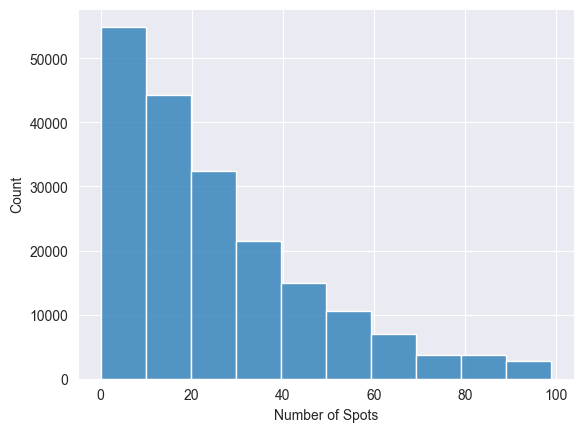

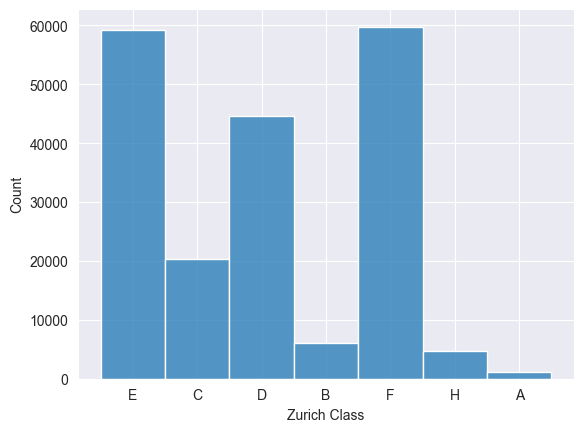

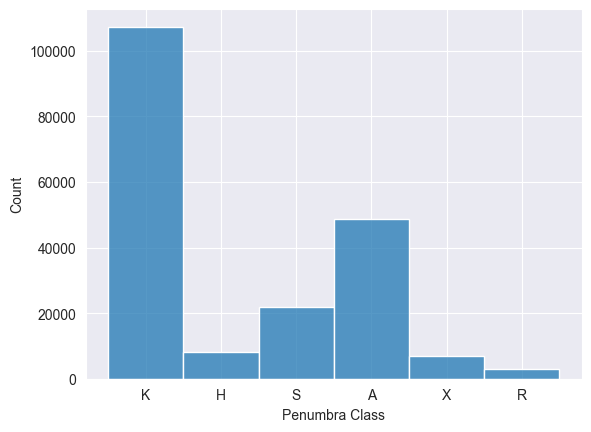

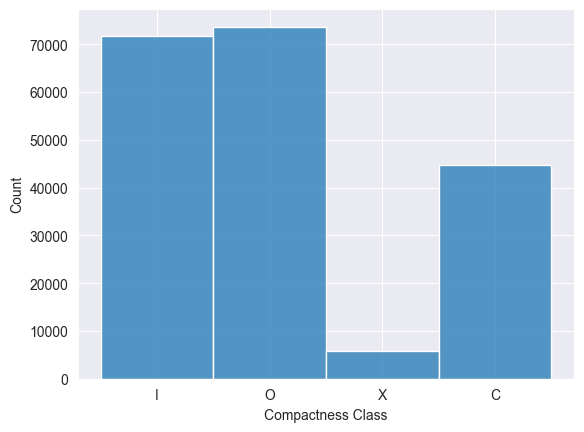

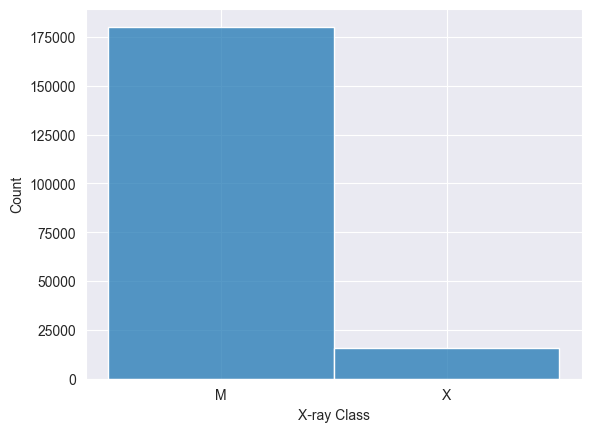

In [57]:
for i, col in enumerate(sunspot_and_solar_flares.columns):
  plt.figure(i)
  sns.histplot(x = col, data = sunspot_and_solar_flares, bins =10)

plt.show()

In [58]:
sunspot_and_solar_flares.describe()

,Number of Spots
count,195859.000000
mean,25.173232
std,21.640125
min,0.000000
25%,8.000000
50%,19.000000
75%,36.000000
max,99.000000


### Encoding Labels

In [59]:
le = LabelEncoder()
sunspot_and_solar_flares['Zurich Class'] = le.fit_transform(sunspot_and_solar_flares['Zurich Class'])
sunspot_and_solar_flares['Penumbra Class'] = le.fit_transform(sunspot_and_solar_flares['Penumbra Class'])
sunspot_and_solar_flares['Compactness Class'] = le.fit_transform(sunspot_and_solar_flares['Compactness Class'])
sunspot_and_solar_flares['X-ray Class'] = le.fit_transform(sunspot_and_solar_flares['X-ray Class'])

In [60]:
# sunspot_and_solar_flares.head(100)
sunspot_and_solar_flares.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195859 entries, 1 to 1301190
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Number of Spots    195859 non-null  int64
 1   Zurich Class       195859 non-null  int64
 2   Penumbra Class     195859 non-null  int64
 3   Compactness Class  195859 non-null  int64
 4   X-ray Class        195859 non-null  int64
dtypes: int64(5)
memory usage: 9.0 MB


### Visualising relationship of features of merged dataset

In [61]:
# Correlation matrix to plot heatmap
corr = sunspot_and_solar_flares.corr()
corr

,Number of Spots,Zurich Class,Penumbra Class,Compactness Class,X-ray Class
Number of Spots,1.000000,0.459315,-0.073419,-0.524528,0.024598
Zurich Class,0.459315,1.000000,-0.199445,-0.370978,0.026651
Penumbra Class,-0.073419,-0.199445,1.000000,0.083771,0.009389
Compactness Class,-0.524528,-0.370978,0.083771,1.000000,-0.063966
X-ray Class,0.024598,0.026651,0.009389,-0.063966,1.000000


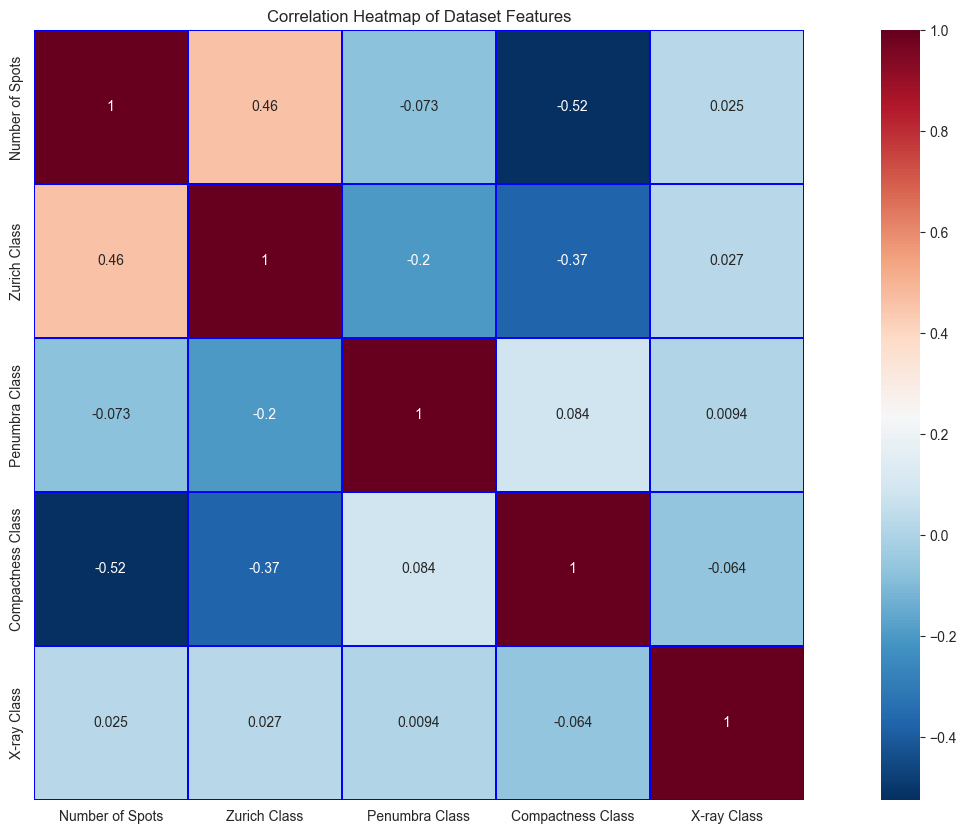

In [62]:
#heat map plot
plt.gcf().set_size_inches((20,10))
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns,
            square=True, linewidths=0.15, cmap=colormap, linecolor='blue', annot=True)
plt.title('Correlation Heatmap of Dataset Features')
plt.show()

### Splitting dataset into training and testing sets for X-ray Class Prediction

In [63]:
x = sunspot_and_solar_flares.drop('X-ray Class', axis=1)
y = sunspot_and_solar_flares['X-ray Class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (137101, 4)
y_train shape: (137101,)
x_test shape: (58758, 4)
y_test shape: (58758,)


### Class balance check & Fix

In [64]:
y_train.value_counts()

0    126130
1     10971
Name: X-ray Class, dtype: int64

<AxesSubplot: xlabel='X-ray Class', ylabel='count'>

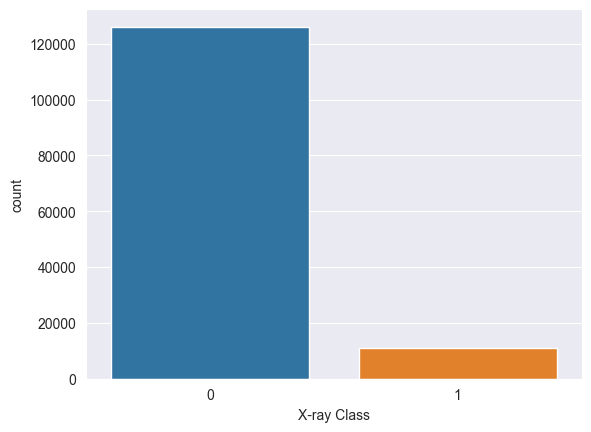

In [65]:
sns.countplot(x=y_train)

In [66]:
smote = SMOTE()
rus = RandomUnderSampler(sampling_strategy=0.5)
x_train_resampled, y_train_resampled= rus.fit_resample(x_train, y_train)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_resampled, y_train_resampled)
y_train_resampled.value_counts()

0    21942
1    21942
Name: X-ray Class, dtype: int64

<AxesSubplot: xlabel='X-ray Class', ylabel='count'>

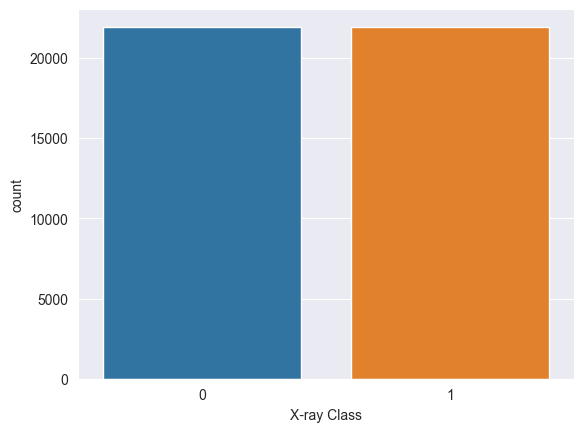

In [67]:
sns.countplot(x=y_train_resampled)

### Feature Scaling

### Training, evaluating and cross validating multiple classification models

KNeighbours ClassifierAccuracy: 0.57 (+/- 0.01)
KNeighbours ClassifierAverage Accuracy Score: 0.567 [5th percentile: 0.558 & 95th percentile:0.578]
KNeighbours ClassifierPrecision: 0.57 (+/- 0.01)
KNeighbours ClassifierAverage Precision Score: 0.566 [5th percentile: 0.558 & 95th percentile:0.579]
KNeighbours ClassifierRecall: 0.57 (+/- 0.04)
KNeighbours ClassifierAverage Recall Score: 0.574 [5th percentile: 0.548 & 95th percentile:0.596]
KNeighbours ClassifierF1: 0.57 (+/- 0.02)
KNeighbours ClassifierAverage F1 Score: 0.571 [5th percentile: 0.556 & 95th percentile:0.586]


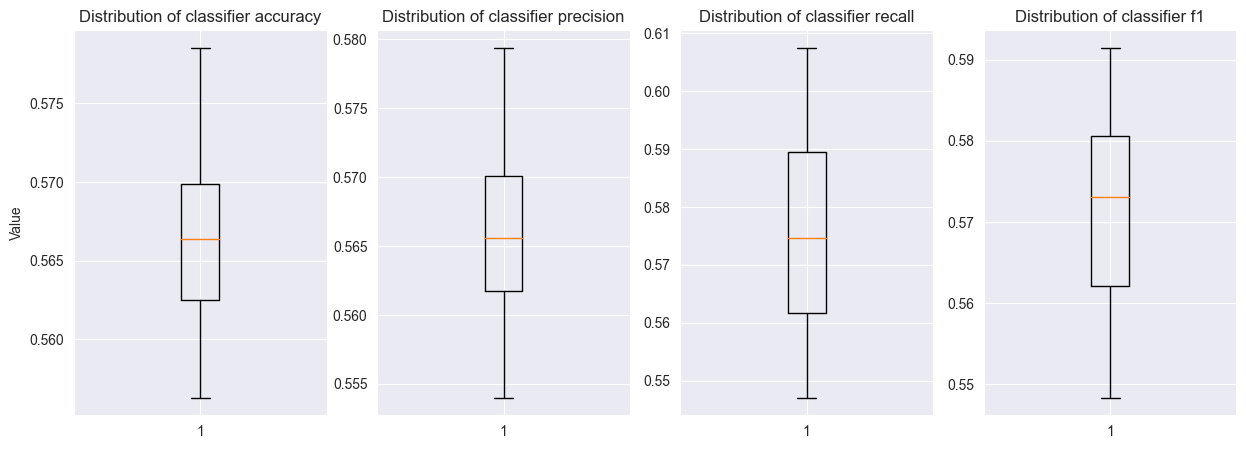

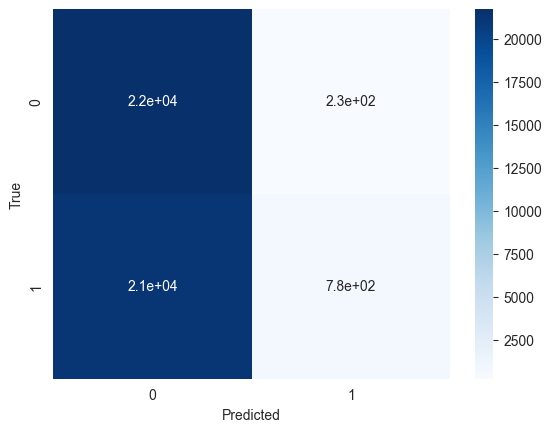

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


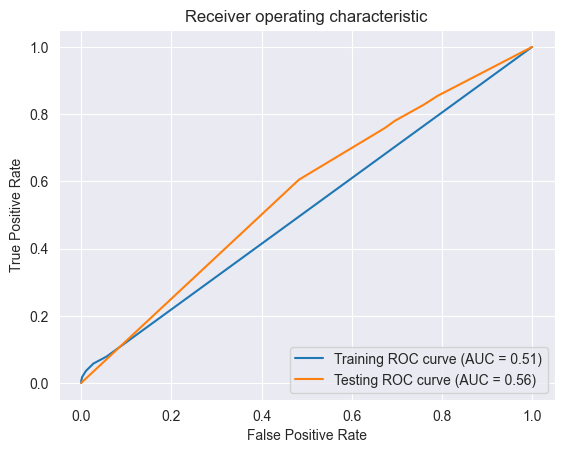

Decision Tree ClassifierAccuracy: 0.60 (+/- 0.01)
Decision Tree ClassifierAverage Accuracy Score: 0.6 [5th percentile: 0.593 & 95th percentile:0.606]
Decision Tree ClassifierPrecision: 0.59 (+/- 0.01)
Decision Tree ClassifierAverage Precision Score: 0.593 [5th percentile: 0.589 & 95th percentile:0.601]
Decision Tree ClassifierRecall: 0.64 (+/- 0.02)
Decision Tree ClassifierAverage Recall Score: 0.635 [5th percentile: 0.619 & 95th percentile:0.653]
Decision Tree ClassifierF1: 0.61 (+/- 0.01)
Decision Tree ClassifierAverage F1 Score: 0.613 [5th percentile: 0.606 & 95th percentile:0.619]


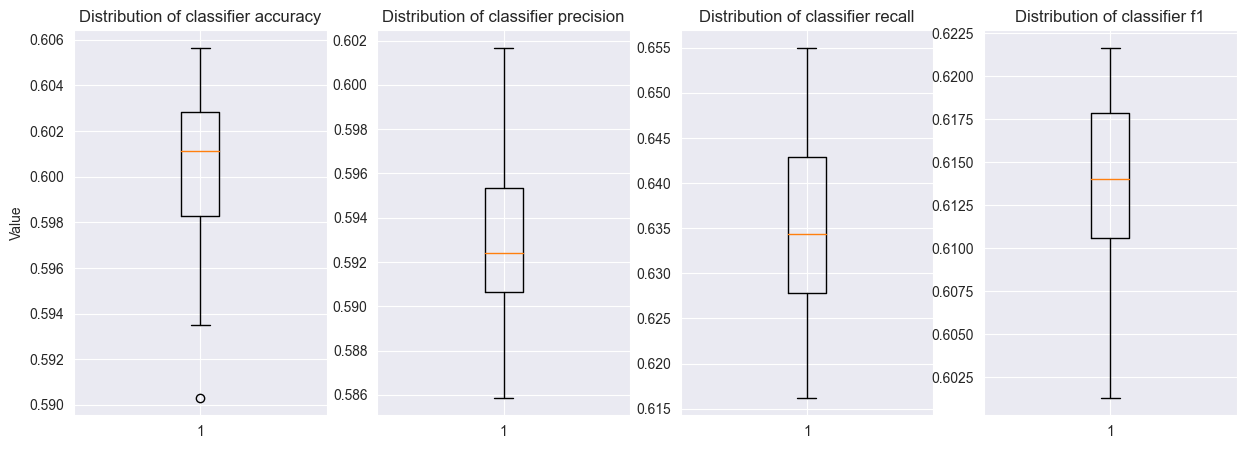

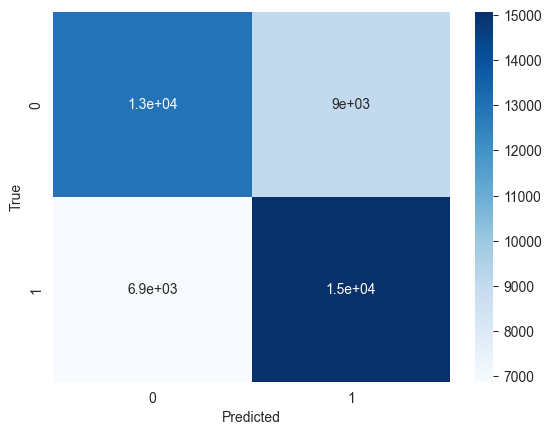

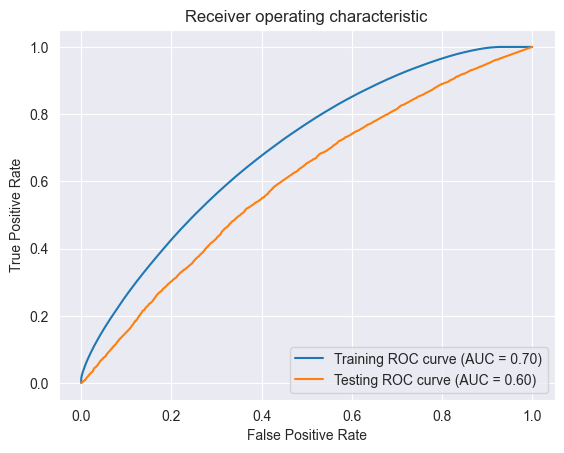

Random Forest ClassifierAccuracy: 0.60 (+/- 0.01)
Random Forest ClassifierAverage Accuracy Score: 0.601 [5th percentile: 0.594 & 95th percentile:0.606]
Random Forest ClassifierPrecision: 0.59 (+/- 0.01)
Random Forest ClassifierAverage Precision Score: 0.592 [5th percentile: 0.585 & 95th percentile:0.597]
Random Forest ClassifierRecall: 0.65 (+/- 0.03)
Random Forest ClassifierAverage Recall Score: 0.65 [5th percentile: 0.634 & 95th percentile:0.667]
Random Forest ClassifierF1: 0.62 (+/- 0.01)
Random Forest ClassifierAverage F1 Score: 0.622 [5th percentile: 0.615 & 95th percentile:0.629]


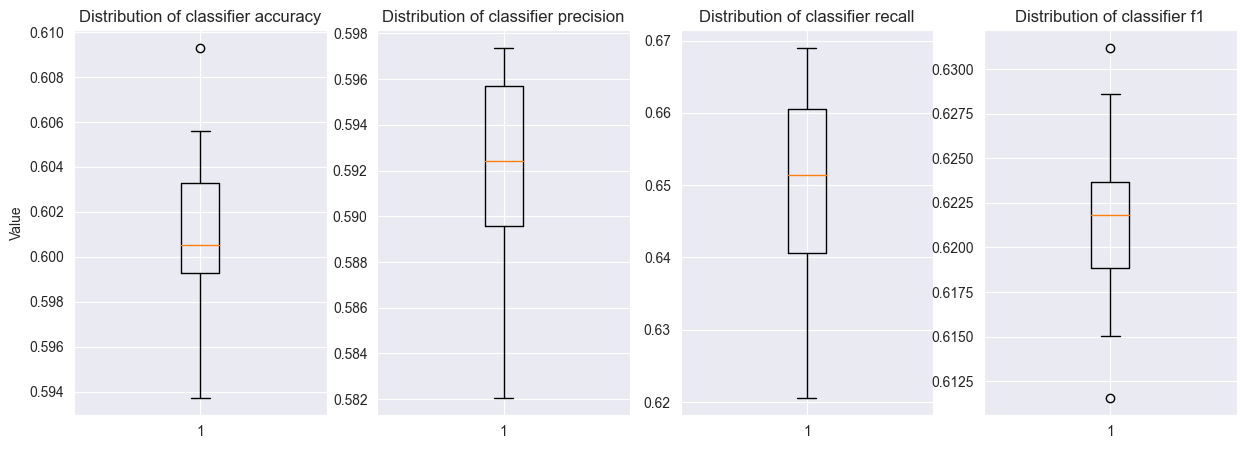

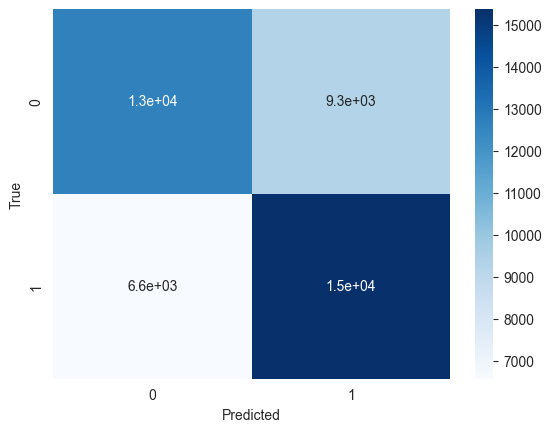

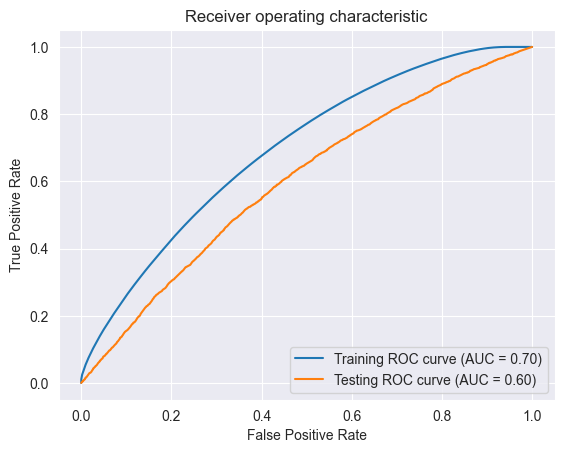

Gradient Boosting ClassifierAccuracy: 0.59 (+/- 0.01)
Gradient Boosting ClassifierAverage Accuracy Score: 0.588 [5th percentile: 0.585 & 95th percentile:0.592]
Gradient Boosting ClassifierPrecision: 0.58 (+/- 0.01)
Gradient Boosting ClassifierAverage Precision Score: 0.584 [5th percentile: 0.575 & 95th percentile:0.59]
Gradient Boosting ClassifierRecall: 0.62 (+/- 0.03)
Gradient Boosting ClassifierAverage Recall Score: 0.625 [5th percentile: 0.601 & 95th percentile:0.643]
Gradient Boosting ClassifierF1: 0.60 (+/- 0.02)
Gradient Boosting ClassifierAverage F1 Score: 0.603 [5th percentile: 0.589 & 95th percentile:0.615]


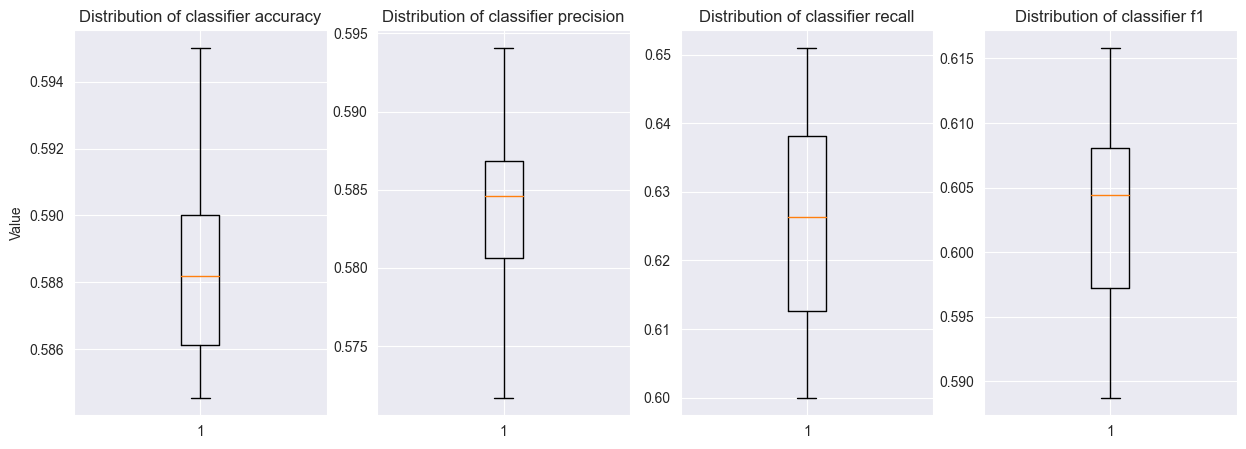

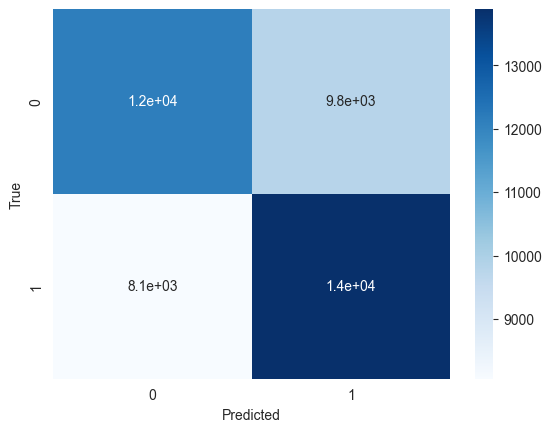

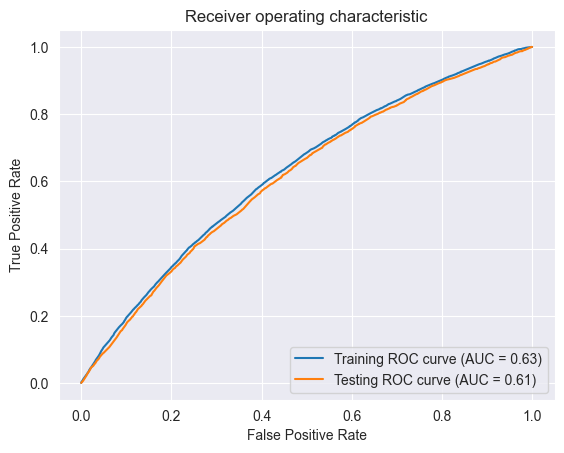

In [69]:
models = {
    'KNeighbours Classifier':  KNeighborsClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
}

for name, model in models.items():

    x_scaled = x_train_resampled

    # Feature
    if name == 'KNeighbours Classifier':
        scaler = MinMaxScaler()
        x_scaled = scaler.fit_transform(x_train_resampled)

    # Cross validation with shufflesplit
    rs = ShuffleSplit(n_splits=20, test_size=0.3)

    accuracy_scorer = make_scorer(accuracy_score)
    precision_scorer = make_scorer(precision_score, zero_division=0)
    recall_scorer = make_scorer(recall_score)
    f1_scorer = make_scorer(f1_score)

    accuracy_results = cross_validate(model, x_scaled, y_train_resampled, cv=rs, scoring=accuracy_scorer, return_train_score=False)
    precision_results = cross_validate(model, x_scaled, y_train_resampled, cv=rs, scoring=precision_scorer)
    recall_results = cross_validate(model, x_scaled, y_train_resampled, cv=rs, scoring=recall_scorer)
    f1_results = cross_validate(model, x_scaled, y_train_resampled, cv=rs, scoring=f1_scorer)

    model.fit(x_scaled, y_train_resampled)
    y_pred = model.predict(x_scaled)

    accuracy_scores = pd.Series(accuracy_results['test_score'])
    precision_scores = pd.Series(precision_results['test_score'])
    recall_scores = pd.Series(recall_results['test_score'])
    f1_scores = pd.Series(f1_results['test_score'])

    result = {
        'name' : name,
        'accuracy_scores': accuracy_scores,
        'precision_scores': precision_scores,
        'recall_scores': recall_scores,
        'f1_scores': f1_scores,
    }

    metrics_box_plot(name, accuracy_scores, precision_scores, recall_scores, f1_scores)

    # Plotting confusion matrix for true positive and predicted
    cm = confusion_matrix(y_train_resampled, y_pred)
    sns.heatmap(cm, annot=True, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    #plot roc
    plot_roc_curve(model, x_scaled, y_train_resampled, x_test, y_test)